# Multi-Agent Architectures

We know that an agent is a system that uses an LLM to decide the control flow of an application

As you develop these systems, they might grow more complex over time, making them harder to manage and scale.

For example, you might run into the following problems:

1. Agent has too many tools at its disposal and makes poor decisions about which tool to call next

2. context grows too complex for a single agent to keep track of

3. there is a need for multiple specialization areas in the system(eg. planner, researcher, math expert, etc.)

To Tackle these , you might consider breaking your application into multiple smaller, independent agents and composing them into multi-agent systems

These independent agents can be as simple as a prompt and an LLM call, or as complex as a ReACT agent

### The primary benefits of using multi-agent systems are:

1. Modularity: Separate agents make it easier to develop, test, and maintain agentic systems

2. Specialization: You can create expert agents focused on specific domains, which helps with the overall system performance.

3. Control: You can explicitly control how agents communicate (as opposed to relying on function calling)

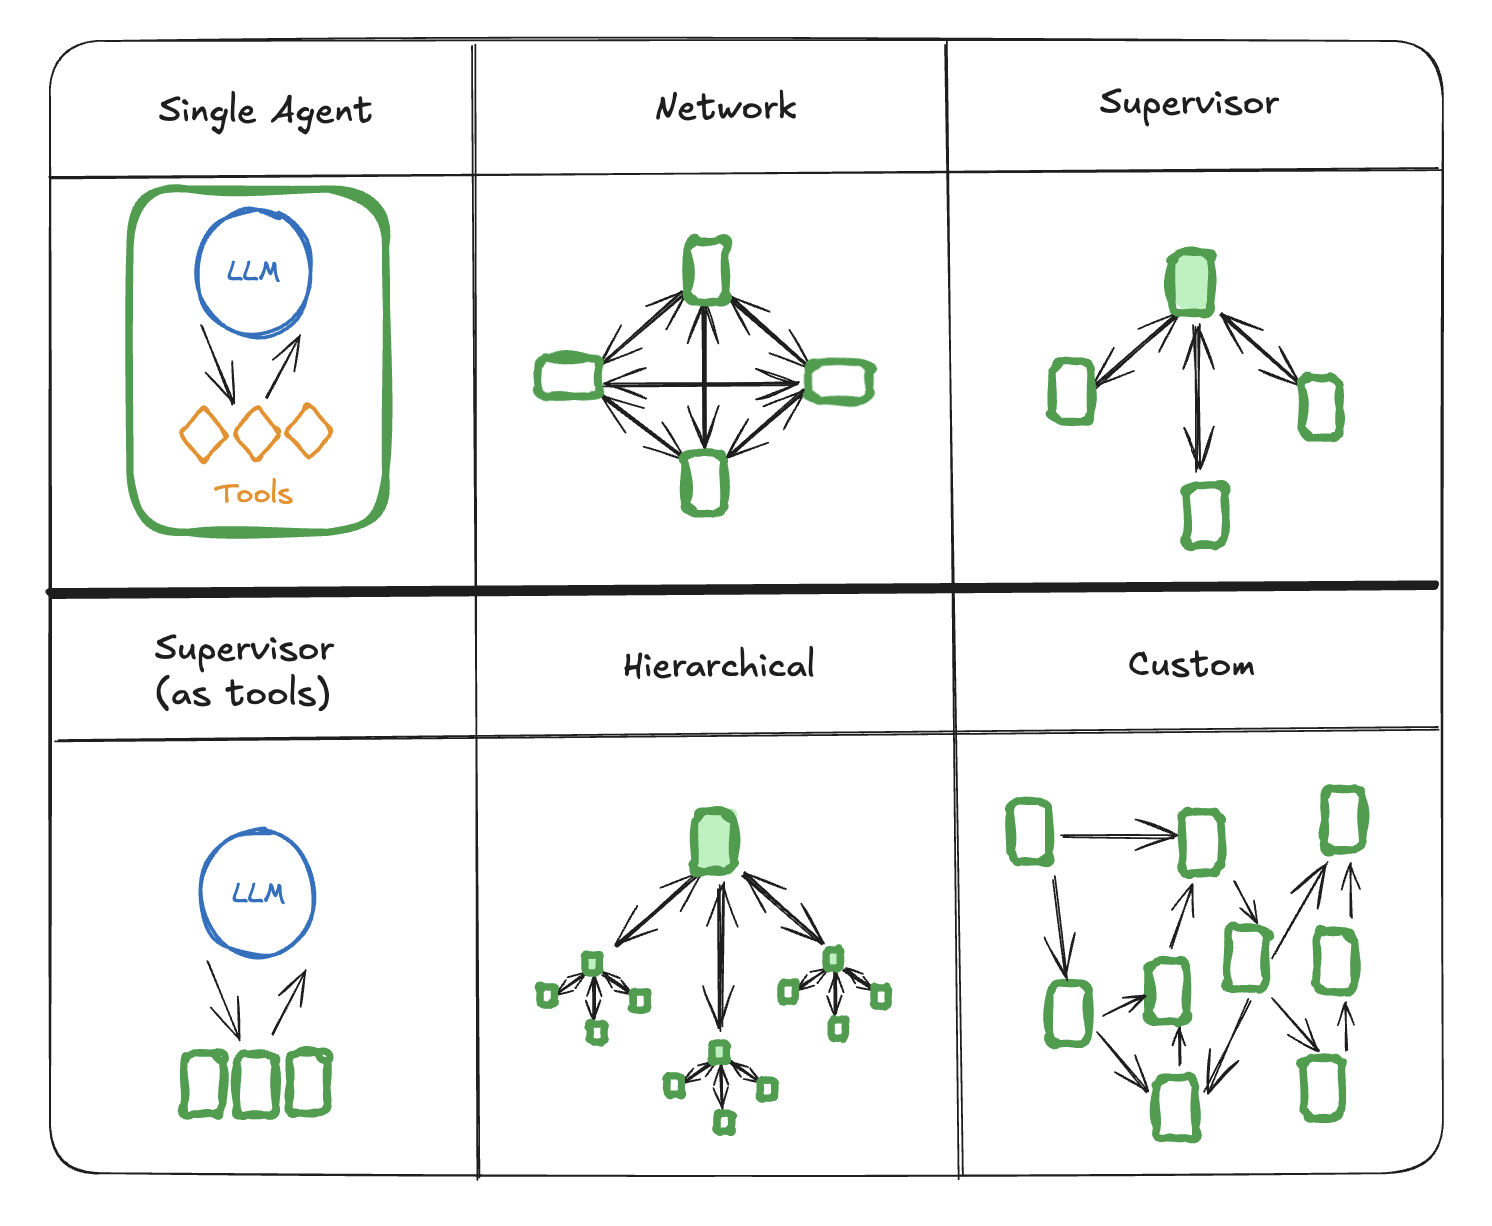

## Subgraphs

Subgraphs allow you to build complex systems with multiple components that are themselves graphs.

A common use case for using subgraphs is building multi-agent-systems.

The main question when adding subgraphs is how the parent graph and subgraph communicate, i.e how they pass the state between each other during the graph execution.

There are two scenarios:

1. parent graph ad subgraph share schema keys. In this case, you can add a node with the compiled subgraph

2. parent graph and subgraph have different schemas. In this case, you have to add a node function that invokes the subgraph: this is useful when the parent graph and the subgraph have different state schemas and you need to transform state before or after calling the subgraph



In [ ]:
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from typing import Annotated, TypedDict
from dotenv import load_dotenv

load_dotenv()


class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.3-70b-versatile")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END


tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges(
    "agent",
    tools_router, {
        "tool_node": "tool_node",
         END: END,
    }
    )


subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

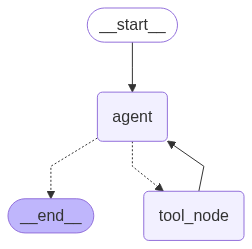

In [24]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [25]:
search_app.invoke({"messages": [HumanMessage(content="What is Quantum Entanglement?")]})

{'messages': [HumanMessage(content='What is Quantum Entanglement?', additional_kwargs={}, response_metadata={}, id='59573847-fbfe-422e-9ae7-c022b40761cb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'sr9fg8rc5', 'function': {'arguments': '{"query":"Quantum Entanglement definition"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 285, 'total_tokens': 308, 'completion_time': 0.054573063, 'prompt_time': 0.035175508, 'queue_time': 0.208638467, 'total_time': 0.089748571}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e48ce73c-8c83-42e9-9e01-139a7eb353e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Quantum Entanglement definition'}, 'id': 'sr9fg8rc5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 23,

### Case 1: Shared Schema (Direct Embedding)

In [27]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="What is Quantum Entanglement?")]})
result

{'messages': [HumanMessage(content='What is Quantum Entanglement?', additional_kwargs={}, response_metadata={}, id='2b4d6b17-20c3-4ca9-872b-afce7e66ea3a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'b3f294dgp', 'function': {'arguments': '{"query":"Quantum Entanglement definition"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 285, 'total_tokens': 308, 'completion_time': 0.065424579, 'prompt_time': 0.032105149, 'queue_time': 0.244292276, 'total_time': 0.097529728}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ded346b8-44c4-444a-b161-77a65e0d97b4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Quantum Entanglement definition'}, 'id': 'b3f294dgp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 23,

### Case 2: Different Schema (Invoke with Transformation)

In [28]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }

    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)

    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "What is Quantum Entanglement?", "response": ""})
print(result)


{'query': 'What is Quantum Entanglement?', 'response': "Quantum Entanglement is a process where two or more quantum systems become correlated in such a way that the state of one system cannot be described independently of the others, even when they are separated by large distances. This means that measuring the state of one system will instantly affect the state of the other entangled systems, regardless of the distance between them. Quantum entanglement is a fundamental aspect of quantum mechanics and has been experimentally confirmed numerous times. It is a key feature of quantum non-locality, which allows for quantum correlations to violate classical probability's inequalities respected by all models satisfying basic locality and causality assumptions."}
